# Text as data workshop (Part 1.2)

Qixuan Yang, Ph.D. student. Yale University. Contact: qixuan.yang@yale.edu

## Beyond information extraction: (Descriptive) inference with text data

- Given we have a certain amount of documents (no need to be _big data_!), how can we describe certain interesting aspects of the _corpus_?
- We have to be very careful about:

  - Definition of documents and creation of a corpus
  - Bag of words assumption in many common methods
  - Interpretation of the results


We use the example of the European Council Conclusions (codebook: https://comparativeagendas.s3.amazonaws.com/codebookfiles/EU_Codebook_3.3_April-2014_ECC_MC-comments_3.pdf). The researchers have annotated the data in terms of different topics at the quasi-sentence level. Overall, the data contains 78 conclusions with over 48,000 quasi-sentences. 

In [ ]:
! wget https://comparativeagendas.s3.amazonaws.com/datasetfiles/ECC_7.0_1975-2014_1.csv

--2022-11-28 15:45:23--  https://comparativeagendas.s3.amazonaws.com/datasetfiles/ECC_7.0_1975-2014_1.csv
Resolving comparativeagendas.s3.amazonaws.com (comparativeagendas.s3.amazonaws.com)... 52.216.245.148, 52.217.0.188, 54.231.166.169, ...
Connecting to comparativeagendas.s3.amazonaws.com (comparativeagendas.s3.amazonaws.com)|52.216.245.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37436572 (36M) [text/csv]
Saving to: ‘ECC_7.0_1975-2014_1.csv’

ECC_7.0_1975-2014_1 100%[===================>]  35.70M  82.3MB/s    in 0.4s    

2022-11-28 15:45:23 (82.3 MB/s) - ‘ECC_7.0_1975-2014_1.csv’ saved [37436572/37436572]



In [ ]:
# Load all special packages for text analysis

! pip3 install scikit-learn>=1.0.0
! pip3 install spacy==3.4.1
! pip3 install scikit-learn==1.0.2
! python -m spacy download en_core_web_md
! pip3 install pytextrank
! pip3 install gensim==4.2.0
! pip3 install pyLDAvis
! pip3 install mapie
! pip3 install eli5
! pip3 install wordcloud
! pip3 install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 50 kB/s 
     |████████████████████████████████| 11.1 MB 30.4 MB/s 
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.2
    Uninstalling pydantic-1.10.2:
      Successfully uninstalled pydantic-1.10.2
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.3
    Uninstalling spacy-3.4.3:
      Successfully uninstalled spacy-3.4.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-11-28 15:46:09.024883: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=51b5b3e61785038f24ac1cf1bf0cfdf0aaeb2bda43f0223de1e9273a74c8fc37
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=dfa9f95e5c

In [ ]:
topic_mapper = {
    0: "None", 1: "Macroeconomics", 2: "Civil Rights, Minority Issues and Civil Liberties", 3: "Health", 4: "Agriculture and Fisheries",
    5: "Labour and Employment", 6: "Education", 7: "Environment", 8: "Energy", 9: "Immigration", 10: "Transportation",
    12: "Law and Crime", 13: "Social Policy", 14: "Regional and Urban Policy and Planning", 15: "Banking, Finance and Internal Trade",
    16: "Defence", 17: "Space, Science, Technology and Communications", 18: "Foreign Trade", 19: "International Affairs and Foreign Aid",
    20: "EU Governance and Government Operations", 21: "Public Lands, Water Management and Territorial Issues", 22: "Culture and Media",
}

## 1. Inspect the data

For this exercise, we are interested in the temporal and topical patterns

In [ ]:
import pandas as pd
from plotnine import *

In [ ]:
# Read and clean the data

data = pd.read_csv("ECC_7.0_1975-2014_1.csv", encoding = 'unicode_escape')
data = data[data["filter_junk"] == 0]  # Remove junk sentences according to authors' definitions
data["subtopic_eu_text"] = data["subtopic_eu"].apply(lambda x: topic_mapper.get(x))

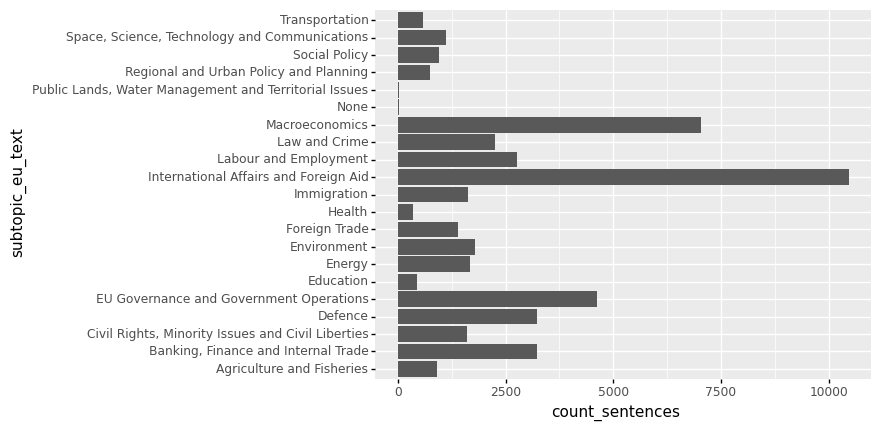

<ggplot: (8791904219241)>

In [ ]:
# Inspect the topic distribution

data_topic_summary = data.groupby("subtopic_eu_text")["id"].count().reset_index()
data_topic_summary.columns = ["subtopic_eu_text", "count_sentences"]

(
    ggplot(aes(x="subtopic_eu_text", y="count_sentences"), data=data_topic_summary) + 
      geom_bar(stat="identity") +
      coord_flip()
)

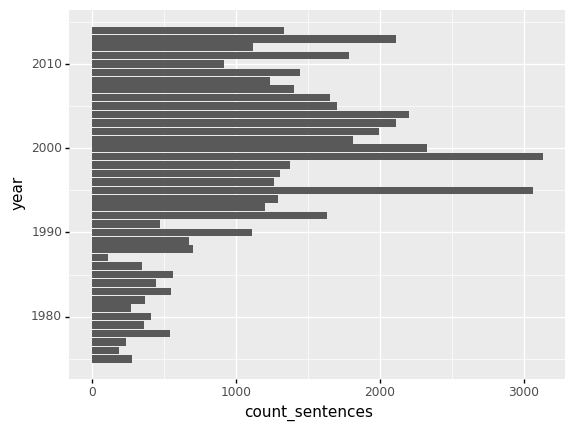

<ggplot: (8791899388697)>

In [ ]:
# Inspect the distribution of number of sentences

data_year_summary = data.groupby("year")["id"].count().reset_index()
data_year_summary.columns = ["year", "count_sentences"]

(
    ggplot(aes(x="year", y="count_sentences"), data=data_year_summary) + 
      geom_bar(stat="identity") +
      coord_flip()
)

## 2. Find _important_ words or phrases in a set of _documents_ (here: sentences) about immigration

### 2.1 Counting words (I): Countvectorizer without any preprocessing

**Definition of importance here**: Words that occur very frequently.

**Procedure**: We count the word occurrences at the sentence level and then sum up

#### 2.1.1 Inspect the data

In [ ]:
# We take a look at all immigration sentences

data_immigration = data[data["subtopic_eu_text"] == "Immigration"]

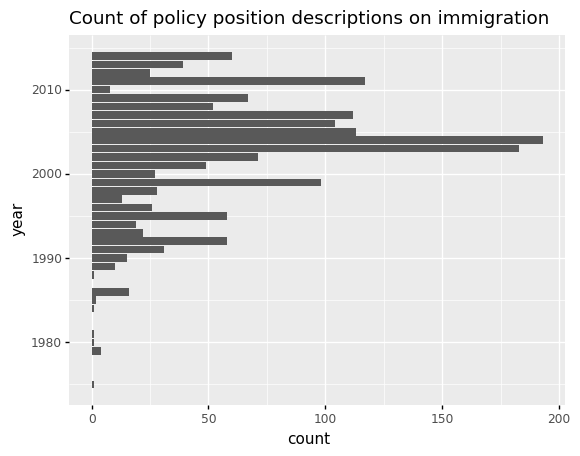

<ggplot: (8791899384177)>

In [ ]:
(
    ggplot(aes(x="year"), data=data_immigration) + 
      geom_bar() +
      ggtitle("Count of policy position descriptions on immigration") +
      coord_flip()
)

#### 2.1.2 Use `CountVectorizer` from sklearn package to count the words. Starting with vanilla models

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Now, we extract sentences (in the description column) for further analyses
immigration_sentences = data_immigration["description"].tolist()

In [ ]:
# Vanilla model
# Step 1: We create a CountVectorizer model. We want to count single tokens. Therefore, the analyzer is at 'word' level and the ngram range is set to 1
count_vectorizer_vanilla = CountVectorizer(analyzer='word', ngram_range=(1, 1))

# Step 2: We use the created model to fit the immigration sentences
eu_all_words_vanilla = count_vectorizer_vanilla.fit_transform(immigration_sentences)

In [ ]:
# Result: 1625 sentences and 2506 disctinct words
eu_all_words_vanilla

<1625x2506 sparse matrix of type '<class 'numpy.int64'>'
	with 23685 stored elements in Compressed Sparse Row format>

In [ ]:
# Now, we sum up the appearences of each of the unique words among all immigration documents
pd.DataFrame(
    {
    "word": count_vectorizer_vanilla.get_feature_names_out(),
    "count": np.squeeze(np.asarray(eu_all_words_vanilla.sum(axis=0)))
    }
).sort_values("count", ascending = False).head(20)

word  count
2281          the   2826
1571           of   1403
259           and   1094
2317           to   1011
1206           in    777
1582           on    515
892      european    466
627       council    448
1009          for    382
2473         with    300
1478    migration    289
298            as    256
350            be    241
401            by    211
1467       member    190
2159       states    183
314        asylum    183
630     countries    157
484    commission    154
1188  immigration    147

In [ ]:
# Vanilla 2: We increase the ngram to 2
count_vectorizer_vanilla_2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
eu_all_words_vanilla_2 = count_vectorizer_vanilla_2.fit_transform(immigration_sentences)

In [ ]:
pd.DataFrame(
    {
    "word": count_vectorizer_vanilla_2.get_feature_names_out(),
    "count": np.squeeze(np.asarray(eu_all_words_vanilla_2.sum(axis=0)))
    }
).sort_values("count", ascending = False).head(20)

word  count
11358               the   2826
7826                 of   1403
976                 and   1094
12281                to   1011
5860                 in    777
8192                 on    515
4428           european    466
3299            council    448
8136             of the    404
4862                for    382
11537      the european    376
4438   european council    315
13270              with    300
7304          migration    289
1635                 as    256
1945                 be    241
2334                 by    211
8327             on the    197
6027             in the    191
7267             member    190

### 2.2 Countvectorizer with preprocessing

**Definition of importance here**: Semantically distinct, non-stop words that occur very frequently.

**Procedure**: We count the word occurrences at the sentence level and then sum up. Here, a word will be normalized by its lemma and we remove words that are identified as common stopwords

#### 2.2.1 Preprocessing with spaCy: Lemmatization and word types

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
spacy.explain("PROPN")

'proper noun'

In [ ]:
spacy.explain("NOUN")

'noun'

In [ ]:
spacy.explain("VERB")

'verb'

In [ ]:
spacy.explain("ADJ")

'adjective'

In [ ]:
spacy.explain("ADV")

'adverb'

In [ ]:
# Useful knowledge for later:
# Since the output of spaCy is a list of tokens
# We generally want to _merge_ the tokens together back to make it look like a document
# We use the .join() function in Python to do the trick
" ".join(["a", "b", "c"])

'a b c'

In [ ]:
# Preprocessing

# Empty list for lemmatized tokens
lst_doc_tokens_lemma = list()

# Empty list for lemmatized tokens, but only nouns and verbs
lst_doc_nv_lemma = list()

for doc in nlp.pipe(immigration_sentences):
  # Clean tokens
  doc_tokens = [token for token in doc if token.is_stop is False and token.like_num is False and len(token.lemma_) > 2]

  # Extract lemmas
  doc_tokens_lemma = [token.lemma_ for token in doc_tokens]

  # Extract lemmas only of nouns and verbs
  doc_nv_lemma = [token.lemma_ for token in doc_tokens if token.pos_ in ["PROPN", "NOUN", "VERB"]]

  # Reconstruct the sentences such that Vectorizer can understand: We combine words with a white space -> a "cleaned" sentence
  lst_doc_tokens_lemma.append(" ".join(doc_tokens_lemma))
  lst_doc_nv_lemma.append(" ".join(doc_nv_lemma))

In [ ]:
{
    "raw": immigration_sentences[711],
    "lemmatized w/o stopwords": lst_doc_tokens_lemma[711],
    "lemmatized nouns and verbs": lst_doc_nv_lemma[711],
}

{'raw': 'and invites all Member States, Acceding States and Candidate States to cooperate fully with the Commission to this end',
 'lemmatized w/o stopwords': 'invite Member States accede States Candidate States cooperate fully Commission end',
 'lemmatized nouns and verbs': 'invite Member States accede States Candidate States cooperate Commission end'}

#### 2.2.2 `CountVectorizer` with spaCy-preprocessed documents - all lemmatized non-stopword tokens

In [ ]:
count_vectorizer_2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
eu_all_words_wo_stop = count_vectorizer_2.fit_transform(lst_doc_tokens_lemma)

In [ ]:
pd.DataFrame(
    {
    "word": count_vectorizer_2.get_feature_names_out(),
    "count": np.squeeze(np.asarray(eu_all_words_wo_stop.sum(axis=0)))
    }
).sort_values("count", ascending = False).head(20)

word  count
3461          european    466
2251           council    448
3470  european council    315
5797         migration    289
2386           country    217
1081            border    204
5762            member    191
834             asylum    183
8901            states    180
5766     member states    172
6888            policy    156
1498        commission    154
4493       immigration    147
1584            common    124
2156       cooperation    112
9735             union    109
4456           illegal    107
3683          external     99
9305            system     97
6113              need     94

In [ ]:
# Rethinking stopwords: Those words that do not give you additional information with regard to the corpus of interest
custom_stop_words = ["european", "union", "council", "member", "states", "commission", "policy", "government"]

# And perhaps the ngrams with 2 or 3 tokens are more interesting than single words as they give more context
count_vectorizer_2 = CountVectorizer(analyzer='word', ngram_range=(2,3), stop_words=custom_stop_words)
eu_all_words_wo_stop = count_vectorizer_2.fit_transform(lst_doc_tokens_lemma)

count_vectorizer_2_result = pd.DataFrame(
    {
    "word": count_vectorizer_2.get_feature_names_out(),
    "count": np.squeeze(np.asarray(eu_all_words_wo_stop.sum(axis=0)))
    }
)

count_vectorizer_2_result.sort_values("count", ascending = False).head(20)

word  count
6002              external border     71
7258          illegal immigration     64
3937             country national     47
2630                common asylum     33
1879               border control     30
3962               country origin     28
9763               migration flow     28
7960           information system     27
1533                asylum system     27
2551               combat illegal     24
6845              global approach     24
3688          cooperation country     23
9238          management external     23
9239   management external border     23
7283            illegal migration     22
1946            border management     22
1084           approach migration     22
14706               soon possible     21
12870       readmission agreement     20
15486                take account     20

#### 2.2.3 `CountVectorizer` with spaCy-preprocessed documents - all lemmatized non-stopword tokens that are nouns or verbs

In [ ]:
count_vectorizer_3 = CountVectorizer(analyzer='word', ngram_range=(2, 3), stop_words=custom_stop_words)
eu_nv_words_wo_stop = count_vectorizer_3.fit_transform(lst_doc_nv_lemma)

count_vectorizer_3_result = pd.DataFrame(
    {
    "word": count_vectorizer_3.get_feature_names_out(),
    "count": np.squeeze(np.asarray(eu_nv_words_wo_stop.sum(axis=0)))
    }
)

count_vectorizer_3_result.sort_values("count", ascending = False).head(20)

word  count
3232            country national     47
1593              border control     30
7717              migration flow     28
3257              country origin     28
6304          information system     27
1319               asylum system     27
7223           management border     26
3001         cooperation country     24
1654           border management     22
913           approach migration     22
12138               take account     21
5439             global approach     21
12555       underline importance     20
10022      readmission agreement     20
2107          combat immigration     19
5441   global approach migration     18
2832              control border     17
2168               common asylum     17
3916             displace person     17
8620              origin transit     17

## 2. Let's define the keywords in a different way

**Definition of importance here**: Semantically distinct, non-stop words that occur _moderately_ frequently

**Procedure**: For each word, we count their occurrences and also their document frequencies. We construct a score out of these two components. Here, a word will be normalized by its lemma and we remove words that are identified as common stopwords

For each term, $t$ in a given document $d$, denote all the documents as $D$

$$
\text{TfIdf} = \text{tf}(t, d) \times \text{idf}(t, D)
$$

where term frequency (tf) is

$$
\text{tf}(t,d) = \frac{\text{count}(t \in d)}{\text{count}(\text{number of words } \in d)}
$$

and document frequency (df) is the number of documents of all documents that contains the term (t), divided by the number of documents

$$
\text{df} = \frac{\text{count}(d \in D | t\in d)}{\text{count}(d \in D)}
$$

and the inverse document frequency (idf) as the 

$$
\text{idf} = \log\left(\frac{\text{count}(d \in D)}{\text{count}(d \in D | t\in d)}\right)
$$

In simiple terms, we prefer those words that (a) have a high frequency in a document but (b) do not appear too frequently _among_ all the documents (that's why we use an inverse to penalize it). The most common example are the words "the" and "a": high frequency words that are penalized for appearing in way too many documents

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Now, we know that all tokens with lemmatization might be a better set-up

tfidf_vectorizer_1 = TfidfVectorizer(ngram_range=(2, 3), stop_words=custom_stop_words)
eu_all_words_wo_stop_tfidf = tfidf_vectorizer_1.fit_transform(lst_doc_tokens_lemma)

tfidf_vectorizer_1_result = pd.DataFrame(
    {
    "word": tfidf_vectorizer_1.get_feature_names_out(),
    "tfidf_score": np.squeeze(np.asarray(eu_all_words_wo_stop_tfidf.sum(axis=0)))
    }
)

tfidf_vectorizer_1_result.sort_values("tfidf_score", ascending = False).head(20)

word  tfidf_score
7258         illegal immigration    19.565211
6002             external border    13.882072
1879              border control     9.371287
3937            country national     8.078023
9763              migration flow     7.924546
2630               common asylum     7.903870
7283           illegal migration     7.079884
1946           border management     6.165000
7960          information system     6.000677
1533               asylum system     5.758043
6217               fight illegal     5.640575
9238         management external     5.617308
9239  management external border     5.617308
2551              combat illegal     5.436231
3962              country origin     5.419276
6845             global approach     4.952719
1084          approach migration     4.881414
2552  combat illegal immigration     4.728865
3688         cooperation country     4.698734
8888             legal migration     4.694188

### 3. Visualize the outputs from `CountVectorizer` and `TfIdfVectorizer`

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Define a wordcloud function generating function
def wordcloud_pic_generator(result, score_column):
  data = result.sort_values(score_column, ascending = False).head(20).set_index('word').to_dict()[score_column]
  wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate_from_frequencies(data)

  return wordcloud

Text(0.5, 1.0, 'TFIDF - meaningful tokens, bigram and trigram w/o stopwords')

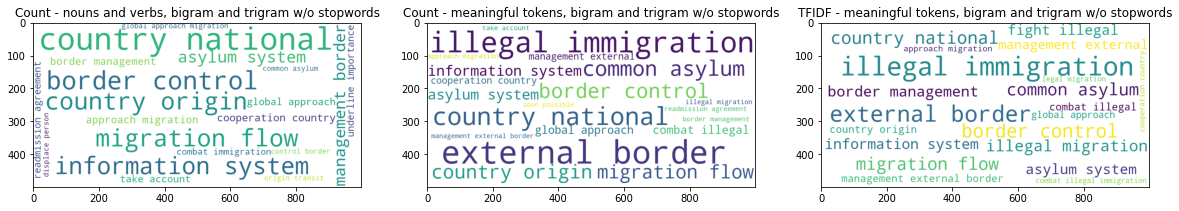

In [ ]:
fig, axs = plt.subplots(1, 3,  figsize=(20,20))


axs[0].imshow(wordcloud_pic_generator(count_vectorizer_3_result, "count"))
axs[0].set_title("Count - nouns and verbs, bigram and trigram w/o stopwords")

axs[1].imshow(wordcloud_pic_generator(count_vectorizer_2_result, "count"))
axs[1].set_title("Count - meaningful tokens, bigram and trigram w/o stopwords")

axs[2].imshow(wordcloud_pic_generator(tfidf_vectorizer_1_result, "tfidf_score"))
axs[2].set_title("TFIDF - meaningful tokens, bigram and trigram w/o stopwords")


### 2.1 Comparing different historical periods

In [ ]:
immigration_sentences_prior_2000 = data_immigration[data_immigration["year"] < 2000]["description"].tolist()
immigration_sentences_after_2000 = data_immigration[data_immigration["year"] >= 2000]["description"].tolist()

In [ ]:
def generate_tfidf(corpus):
  # Step 1: Data cleaning
  lst_doc_tokens_lemma = list()

  for doc in nlp.pipe(corpus):
    # Clean tokens
    doc_tokens = [token for token in doc if token.is_stop is False and token.like_num is False and len(token.lemma_) > 2]

    # Extract lemmas
    doc_tokens_lemma = [token.lemma_ for token in doc_tokens]

    # Reconstruct the sentences such that Vectorizer can understand: We combine words with a white space -> a "cleaned" sentence
    lst_doc_tokens_lemma.append(" ".join(doc_tokens_lemma))
  
  # Step 2: Fit and transform tfidf
  tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3), stop_words=custom_stop_words)
  tfidf_result_raw = tfidf_vectorizer.fit_transform(lst_doc_tokens_lemma)

  # Step 3: Organize the results
  tfidf_vectorizer_result = pd.DataFrame(
      {
        "word": tfidf_vectorizer.get_feature_names_out(),
        "tfidf_score": np.squeeze(np.asarray(tfidf_result_raw.sum(axis=0)))
      }
  )

  return tfidf_vectorizer_result.sort_values("tfidf_score", ascending = False).head(20)


In [ ]:
keywords_prior_2000 = generate_tfidf(immigration_sentences_prior_2000)
keywords_prior_2000

word  tfidf_score
1899          illegal immigration     7.490047
1578            external frontier     3.396773
1095             country national     2.958216
2481           migratory pressure     2.689912
1290              displace person     2.650604
1573              external border     2.492421
410            asylum immigration     2.238035
3295      refugee displace person     2.144427
3294             refugee displace     2.144427
686                 common asylum     2.142236
3544               return refugee     2.034903
431                 asylum seeker     1.734778
1104               country origin     1.528829
1624                 field asylum     1.435533
1141            crossing external     1.391858
1819           harmonization visa     1.283755
2082           information system     1.255511
733            community external     1.224211
734   community external frontier     1.224211
3959         temporary protection     1.210563

In [ ]:
keywords_after_2000 = generate_tfidf(immigration_sentences_after_2000)
keywords_after_2000

word  tfidf_score
5526         illegal immigration    12.781198
4567             external border    11.968275
1418              border control     8.494768
7528              migration flow     7.331245
5544           illegal migration     6.889346
2003               common asylum     5.995423
2937            country national     5.704125
1476           border management     5.542388
7095         management external     5.537848
7096  management external border     5.537848
1136               asylum system     5.192095
6069          information system     5.085566
4729               fight illegal     4.921738
5229             global approach     4.880739
1953              combat illegal     4.669909
6814             legal migration     4.634559
2729         cooperation country     4.609602
819           approach migration     4.517062
5232   global approach migration     4.242259
2956              country origin     4.188103

Text(0.5, 1.0, 'TFIDF after 2000 - meaningful tokens, bigram and trigram w/o stopwords')

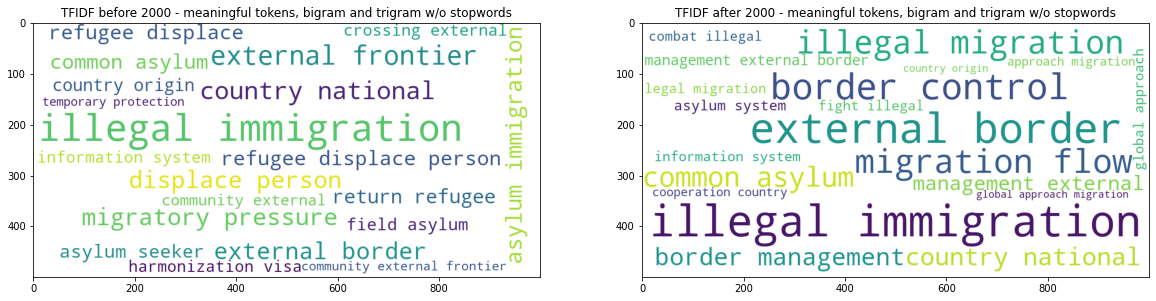

In [ ]:
fig, axs = plt.subplots(1, 2,  figsize=(20, 20))


axs[0].imshow(wordcloud_pic_generator(keywords_prior_2000, "tfidf_score"))
axs[0].set_title("TFIDF before 2000 - meaningful tokens, bigram and trigram w/o stopwords")

axs[1].imshow(wordcloud_pic_generator(keywords_after_2000, "tfidf_score"))
axs[1].set_title("TFIDF after 2000 - meaningful tokens, bigram and trigram w/o stopwords")

In [ ]:
# Discussion

## 3. Optional: Using pytextrank to define keywords

We use the text rank algorithm developed in [TextRank: Bringing Order into Text](https://aclanthology.org/W04-3252) (Mihalcea & Tarau, 2004)

The python implementation is developed by: https://derwen.ai/docs/ptr/


In [ ]:
import pytextrank

In [ ]:
# Add pytextrank to spacy

nlp.add_pipe("textrank")

In [ ]:
# Bringing all sentences together

immigration_all = " ".join(immigration_sentences)

In [ ]:
doc = nlp(immigration_all)

In [ ]:
phrases_list = list()
for phrase in doc._.phrases:
    phrases_list.append((phrase.text, phrase.rank, phrase.count))

In [ ]:
phrases_df = pd.DataFrame(phrases_list)
phrases_df.columns = ["text", "rank", "count"]

In [ ]:
phrases_df.sort_values("rank", ascending=False).head(20)